# Exploring census blocks & joining to 911 data
911 calls file is [here](https://app.box.com/file/911911135646), and was provided manually by Jimmy McBroom, a data engineer for the city. In theory, you should be able to get it from [the open data portal](https://data.detroitmi.gov/datasets/911-calls-for-service/explore)

2010 census blocks can be downloaded [from the census bureau](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2010&layergroup=Blocks) or from [box](https://bloombergdotorg.box.com/s/pzaf2y8u6xmw1rgg8tr4hf7270y3q0rj). This is what detroit uses. It's in Wayne county, so that's all you need to download (its county code is 163).  
Wayne county shares a northern and largely an eastern border with Detroit, and extends further south and west

## General Census block notes
These are hierarchical, and pretty granular in populated areas.

The hierarchy looks like this, where each X is and integer: 
XX|XXX|XXXXXX|XXXX

To avoid counting Xs, the lengths are: 
2|3|6|4

With meanings: 
State | county | tract | block

## 911 calls and census blocks
The block is given by the column block_id with len(block_id)==15

The calls dataset does have null block ids (~3% in the small sample I checked). For each of them, it does have a lat/long, so we can probably figure it out

## Census block shp files
Block is given by the column GEOID10. Very well behaved

## Join notes
In the small sample I tested, the strong majority of these join correctly. like 3% do not due to mising a block ID, and < 1% are in adjacent counties (which we could pull in if we really wanted to)


## Other data with census blocks
Tons of datasets by block through the census [here](https://data.census.gov/cedsci/table?q=United%20States&g=0500000US26163%241000000)
This includes 
* population in occupied units by block. (search `DECENNIALSF12010.H10_data_with_overlays_2022-01-28T162836`)
* Population in various types of households (`DECENNIALSF12010.P30_data_with_overlays_2022-01-28T162836`)


In [142]:
pd.read_csv('/Users/ahakso/Downloads/kx-city-of-detroit-michigan-census-tracts-2010-CSV/city-of-detroit-michigan-census-tracts-2010.csv')

,WKT,aland_10,awater_10,countyfp_1,funcstat_1,geoid_10,intptlat_1,intptlon_1,mtfcc_10,name_10,namelsad_1,statefp_10,tractce_10
0,"POLYGON ((-83.1589256312619 42.2573660623705,-...",1118325,0,163,S,26163524800,42.263100,-83.161591,G5020,5248,Census Tract 5248,26,524800
1,"POLYGON ((-83.076771397333 42.343641331759,-83...",1692449,0,163,S,26163521900,42.350399,-83.080534,G5020,5219,Census Tract 5219,26,521900
2,"POLYGON ((-83.0715633870566 42.3432303356933,-...",224907,0,163,S,26163521800,42.346121,-83.071252,G5020,5218,Census Tract 5218,26,521800
3,"POLYGON ((-83.0848634293549 42.3320142943701,-...",1507941,0,163,S,26163521500,42.336860,-83.076392,G5020,5215,Census Tract 5215,26,521500
4,"POLYGON ((-83.0852754315236 42.3314642931567,-...",1305626,0,163,S,26163521400,42.330584,-83.073016,G5020,5214,Census Tract 5214,26,521400
...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,"POLYGON ((-83.0004214187108 42.3372424818251,-...",3397894,3081417,163,S,26163985500,42.341856,-82.978171,G5020,9855,Census Tract 9855,26,985500
306,"POLYGON ((-82.9548789809586 42.3492707272113,-...",3397894,3081417,163,S,26163985500,42.341856,-82.978171,G5020,9855,Census Tract 9855,26,985500
307,"POLYGON ((-82.9757482772095 42.3476816879467,-...",3397894,3081417,163,S,26163985500,42.341856,-82.978171,G5020,9855,Census Tract 9855,26,985500
308,"POLYGON ((-82.9646410488972 42.3500787624909,-...",3397894,3081417,163,S,26163985500,42.341856,-82.978171,G5020,9855,Census Tract 9855,26,985500


In [63]:
import geopandas as gpd
from util_detroit import kml_to_gpd, csv_with_x_y_to_gpd

# Only read in the columns we want
COLS_911 = [
    "calldescription",
    "call_timestamp",
    "block_id",
    "category",
    "officerinitiated",
    "priority",
    "oid",
    "longitude",
    "latitude"
]

In [64]:
call_sample_size = 100000
call = (
    csv_with_x_y_to_gpd(
        "calls_for_service_from_jimmy.csv",
        crs = 'epsg:4327',
        read_csv_args={"nrows": call_sample_size, "usecols": COLS_911 + ["longitude", "latitude"]},
    )
    #     want to use ints, but default type does not handle nulls. May factorize later
    .astype({"call_timestamp": "datetime64", "block_id": pd.Int64Dtype()}).loc[
        :, COLS_911 + ["geometry"]
    ]
)

census = (
    gpd.read_file(
        "/Users/ahakso/Downloads/wayne_county_census_blocks/tl_2010_26163_tabblock10.shp"
    )
    #     full block id is concatenation of geoid and name. Remove optional `.` delimiter
    .rename(columns={"GEOID10": "block_id"})
    #     Can't go to Int64Dtype from string, convert to int first
    .astype({"block_id": int})
    #     Use type consistent with that used for 911 calls
    .astype({"block_id": pd.Int64Dtype()})
).to_crs("EPSG:4327").loc[:,['block_id','geometry']]

display(census.head(2))
call.head(2)

,block_id,geometry
0,261635032003010,"POLYGON ((-83.00482 42.44610, -83.00500 42.446..."
1,261635032002007,"POLYGON ((-83.00380 42.44354, -83.00503 42.443..."


,calldescription,call_timestamp,block_id,category,officerinitiated,priority,oid,longitude,latitude,geometry
0,TRAFFIC STOP,2020-06-25 14:40:55,261635318001003,TRF STOP,Yes,2,3079296,-83.113801,42.387110,POINT (-83.11380 42.38711)
1,START OF SHIFT INFORMATION,2020-06-25 14:41:21,261635339003014,STRTSHFT,Yes,3,3079297,-83.081518,42.367313,POINT (-83.08152 42.36731)


In [65]:
null_count = call.block_id.isna().sum()
print(f"proportion of call block ids not present in wayne county census block data: {((~call.block_id.isin(census.block_id)).sum())/call.shape[0]:.4f}")
print(f"proportion non-null call block ids not present in wayne county census block data: {((~call.block_id.isin(census.block_id)).sum()-null_count)/(call.shape[0]-null_count):.4f}")

proportion of call block ids not present in wayne county census block data: 0.0248
proportion non-null call block ids not present in wayne county census block data: 0.0026


In [4]:
# reduce census array by dropping censuss where calls are never seen.
# census = census.loc[census.block_id.isin(call.block_id)]

# Join calls and blocks on block_id

In [41]:
id_join = pd.merge(call,census,on='block_id',how='left')
id_join.head()

,calldescription,call_timestamp,block_id,category,officerinitiated,priority,oid,geometry_x,geometry_y
0,TRAFFIC STOP,2020-06-25 14:40:55,261635318001003,TRF STOP,Yes,2,3079296,POINT (-83.11380 42.38711),"POLYGON ((-83.11010 42.38766, -83.11334 42.386..."
1,START OF SHIFT INFORMATION,2020-06-25 14:41:21,261635339003014,STRTSHFT,Yes,3,3079297,POINT (-83.08152 42.36731),"POLYGON ((-83.08151 42.36730, -83.08165 42.367..."
2,DISTURBANCE,2020-06-25 14:41:31,261635129003001,DISTURB,No,3,3079298,POINT (-82.94905 42.37831),"POLYGON ((-82.94905 42.37830, -82.95019 42.377..."
3,DISTURBANCE,2020-06-25 14:41:33,261635352003007,DISTURB,No,3,3079299,POINT (-83.17806 42.37468),"POLYGON ((-83.17805 42.37467, -83.18240 42.374..."
4,SPECIAL ATTENTION,2020-06-25 14:43:07,261635413002003,SPCL ATT,Yes,3,3079300,POINT (-83.28121 42.42880),"POLYGON ((-83.28167 42.42631, -83.28169 42.426..."


# Join calls and block where the calls x/y is in the block's polygon 
Uses 2010 census data for all of wayne county

We have some context from detroit that block_id has no anonymization in it, while lat/long does. Therefore, we expect some mismatch between point/polygon and block_id/block_id


To get a better sense of how often it is happening and how far the snapping can move a data point. We won't have perfect visibility, but if they mostly match (passing the sanity test), then for each call with mismatched block_ids, we can measure the distance between the lat/long and the closest edge of the actual block id – this will give us the minimum it had to have moved in the snapping
We can then look at the distribution of those distances to get some vague sense of how far the snapping can move the point. The max will probably be the most interesting, barring the presence of massive distances which would indicate some sort of upstream error. 

In [42]:
space_join = gpd.sjoin(call.loc[:,['geometry','block_id']], census.loc[:,['block_id','geometry']], how='left', op='intersects',lsuffix='call',rsuffix='census')

In [43]:
space_join.head()

,geometry,block_id_call,index_census,block_id_census
0,POINT (-83.11380 42.38711),261635318001003,16003.0,261635318001002
1,POINT (-83.08152 42.36731),261635339003014,29464.0,261635339003014
2,POINT (-82.94905 42.37831),261635129003001,19823.0,261635129003000
3,POINT (-83.17806 42.37468),261635352003007,23109.0,261635352003007
4,POINT (-83.28121 42.42880),261635413002003,14198.0,261635418001004


In [45]:
unmatched = space_join.block_id_census.isna().sum()
in_block_but_disagreeing=(space_join.dropna(how='any').block_id_call==space_join.dropna(how='any').block_id_census).sum()
print(f"calls not inside a wayne county census block: {unmatched} ({100*unmatched/space_join.shape[0]:.1f})%")
print(f"matched blocks disagreeing: {in_block_but_disagreeing} ({100*in_block_but_disagreeing/space_join.dropna(how='any').shape[0]:.1f})%")


calls not inside a wayne county census block: 3034 (3.0)%
matched blocks disagreeing: 32212 (33.2)%


In [60]:
# west of this longitude, these point are all stacked on top of each other in a random-ass location. 
display(call.loc[lambda x: call.longitude< -84].head())
# these are all null block ids (comprising most, if not all, the missing ids)
call.loc[lambda x: call.longitude< -84].block_id.notna().sum()

,calldescription,call_timestamp,block_id,category,officerinitiated,priority,oid,longitude,latitude,geometry
55,FELONIOUS ASSAULT REPORT,2020-06-25 15:00:58,<NA>,FA RPT,Yes,4,3079351,-84.132207,42.082976,POINT (-84.13221 42.08298)
100,TOWING DETAIL,2020-06-25 15:15:56,<NA>,TOW,Yes,3,3079396,-84.132207,42.082976,POINT (-84.13221 42.08298)
114,WNTD WRRNT FELONY,2020-06-25 15:18:54,<NA>,FELONY,Yes,2,3079410,-84.132207,42.082976,POINT (-84.13221 42.08298)
162,TRAFFIC STOP,2020-06-25 15:30:52,<NA>,TRF STOP,Yes,2,3079458,-84.132207,42.082976,POINT (-84.13221 42.08298)
279,REMARKS,2020-06-25 16:02:41,<NA>,REMARKS,Yes,3,3079576,-84.132207,42.082976,POINT (-84.13221 42.08298)


0

In [107]:
census = census.assign(longitude = lambda x: x.geometry.centroid.x,
              latitude = lambda x: x.geometry.centroid.y)

/var/folders/28/p0bhwx8s3cj150l_wknp1wd80000gp/T/ipykernel_26355/2425136067.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  census = census.assign(longitude = lambda x: x.geometry.centroid.x,
/var/folders/28/p0bhwx8s3cj150l_wknp1wd80000gp/T/ipykernel_26355/2425136067.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = lambda x: x.geometry.centroid.y)


<AxesSubplot:>

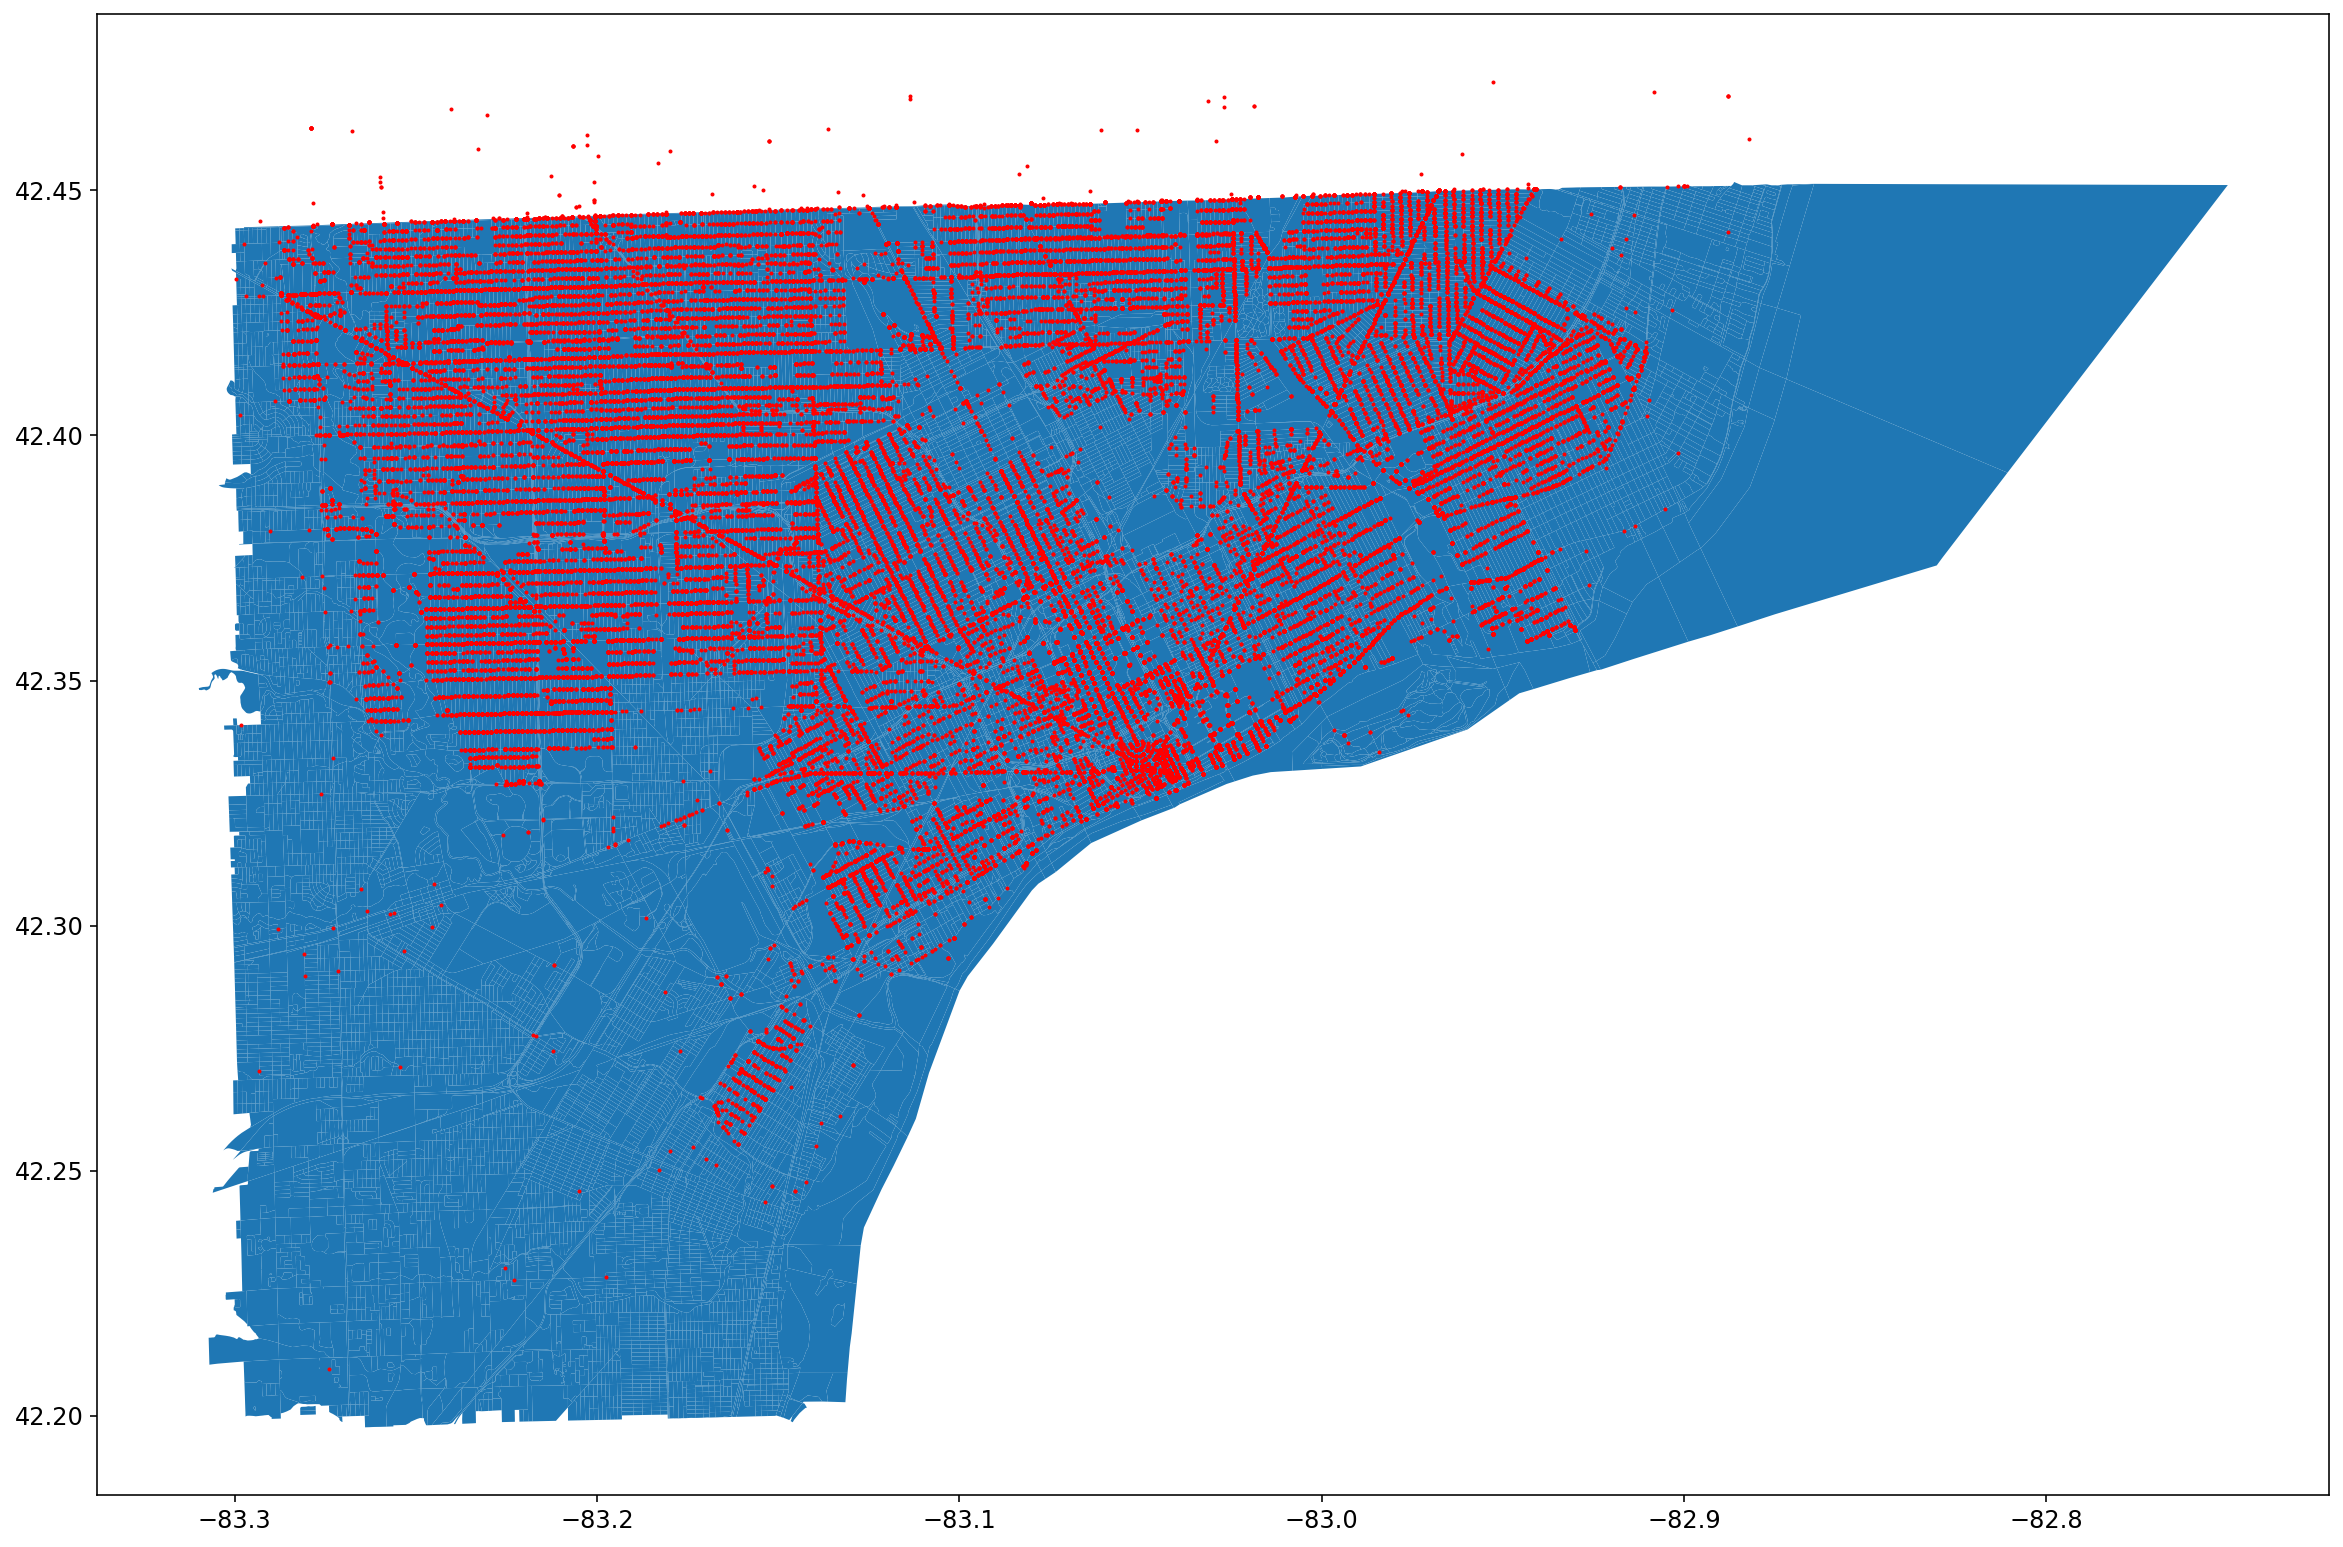

In [109]:
ylim = 42.2
xlim = -83.3
fig, ax = plt.subplots(1,1, figsize=(20,20))
census.loc[lambda x: (x.latitude > ylim) & (x.longitude > xlim)].plot(ax=ax)
# exclude ~2% of call that are stacked on top of each other way outside of detroit
call.loc[lambda x: (x.latitude > ylim) & (x.longitude > xlim)].plot(ax=ax,markersize=1,color='r')

## Just detroit census blocks

In [214]:
from detroit_geos import get_detroit_boundaries, get_detroit_census_blocks
city_bounds = get_detroit_boundaries()

In [208]:
call_in_detroit = call.geometry.within(city_bounds.geometry.iloc[0])

In [212]:
call = call.loc[call_in_detroit]

In [221]:
c20 = get_detroit_census_blocks(2020)
c10 = get_detroit_census_blocks(2010)

In [226]:
df20 = gpd.sjoin(call.loc[:,['geometry','block_id']], c20.loc[:,['block_id','geometry']], how='left', op='intersects',lsuffix='call',rsuffix='census')
df10 = gpd.sjoin(call.loc[:,['geometry','block_id']], c10.loc[:,['block_id','geometry']], how='left', op='intersects',lsuffix='call',rsuffix='census')

In [230]:
df10.isna().sum()

geometry             0
block_id_call        0
index_census       520
block_id_census    520
dtype: int64

In [231]:
df10.loc[df10.index_census.isna()]

,geometry,block_id_call,index_census,block_id_census
67,POINT (-83.00270 42.44891),260992684001023,NaN,NaN
489,POINT (-83.07542 42.44713),261635068001002,NaN,NaN
492,POINT (-82.96794 42.44984),261635002004001,NaN,NaN
549,POINT (-83.00270 42.44891),260992684001023,NaN,NaN
680,POINT (-83.07787 42.44710),261635068002001,NaN,NaN
...,...,...,...,...
99481,POINT (-83.07664 42.44712),261635068001002,NaN,NaN
99514,POINT (-83.03083 42.44802),261635061002000,NaN,NaN
99592,POINT (-83.00519 42.44883),260992684001023,NaN,NaN
99627,POINT (-83.02841 42.44808),261635061001003,NaN,NaN


In [234]:
def join_result(df):
    print(f"proportion matching blocks: {(df.block_id_call==df.block_id_census).sum()/df.shape[0]:.4f}")
    print(f"proportion not placed in a block: {df.index_census.isna().sum()/df.shape[0]:.4f}")
join_result(df10)
join_result(df20)

proportion matching blocks: 0.3308
proportion not placed in a block: 0.0054
proportion matching blocks: 0.0000
proportion not placed in a block: 0.0054


# Census blocks in city boundaries
## 2010

In [151]:
detroit_boundaries = gpd.read_file('/Users/ahakso/Downloads/kx-city-of-detroit-michigan-city-boundary-SHP/city-of-detroit-michigan-city-boundary.shp').to_crs('epsg:4327')

In [173]:
in_detroit = census.loc[[(db.contains(x)) or (db.overlaps(x)) for x in census.geometry]]

<AxesSubplot:>

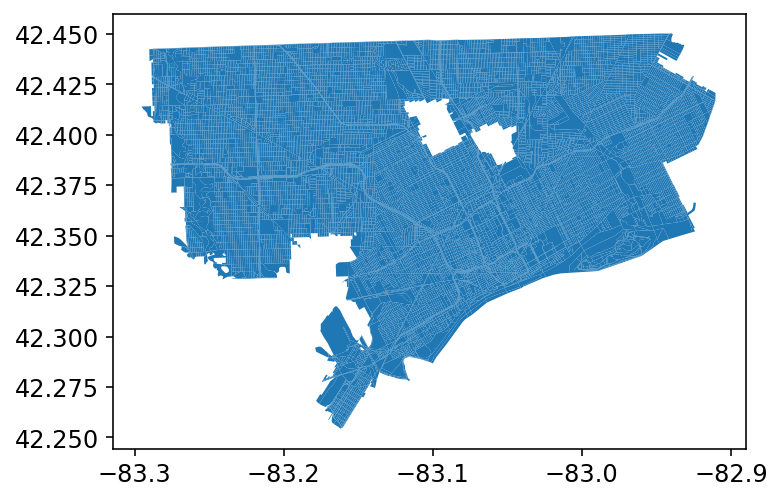

In [174]:
in_detroit.plot()

In [180]:
in_detroit.to_file('/Users/ahakso/Downloads/detroit_census_blocks_2010/blocks_in_detroit.shp')

In [196]:
gpd.read_file('/Users/ahakso/gd/detroit/detroit_census_blocks_2010/blocks_in_detroit.shp')

,block_id,longitude,latitude,geometry
0,261635032003010,-83.004713,42.446729,"POLYGON ((-83.00482 42.44610, -83.00500 42.446..."
1,261635032002007,-83.004452,42.444412,"POLYGON ((-83.00380 42.44354, -83.00503 42.443..."
2,261635032003016,-82.998386,42.446388,"POLYGON ((-82.99773 42.44547, -82.99897 42.445..."
3,261635032003004,-82.995998,42.448212,"POLYGON ((-82.99663 42.44903, -82.99653 42.449..."
4,261635032002014,-82.996993,42.442800,"POLYGON ((-82.99634 42.44191, -82.99757 42.441..."
...,...,...,...,...
16336,261635165001015,-83.013356,42.341514,"POLYGON ((-83.01265 42.34085, -83.01311 42.340..."
16337,261639855001000,-82.962079,42.345889,"POLYGON ((-82.94947 42.34854, -82.95060 42.347..."
16338,261635169001017,-83.032130,42.342512,"POLYGON ((-83.03200 42.34213, -83.03245 42.342..."
16339,261635392006001,-83.198551,42.444828,"POLYGON ((-83.19683 42.44496, -83.19670 42.444..."


## 2020

In [182]:
census_2020 = (
    gpd.read_file(
        "/Users/ahakso/Downloads/tl_2020_26_tabblock20/tl_2020_26_tabblock20.shp"
    )
    #     full block id is concatenation of geoid and name. Remove optional `.` delimiter
    .rename(columns={"GEOID20": "block_id"})
    #     Can't go to Int64Dtype from string, convert to int first
).to_crs("EPSG:4327")#.loc[:,['block_id','geometry']]

In [193]:
census_2020 = census_2020.rename(columns={"GEOID20": "block_id"}).loc[
    lambda x: x.COUNTYFP20 == "163"
].loc[:, ["block_id", "geometry"]]
in_detroit_2020 = census_2020.loc[[(db.contains(x)) or (db.overlaps(x)) for x in census_2020.geometry]]

<AxesSubplot:>

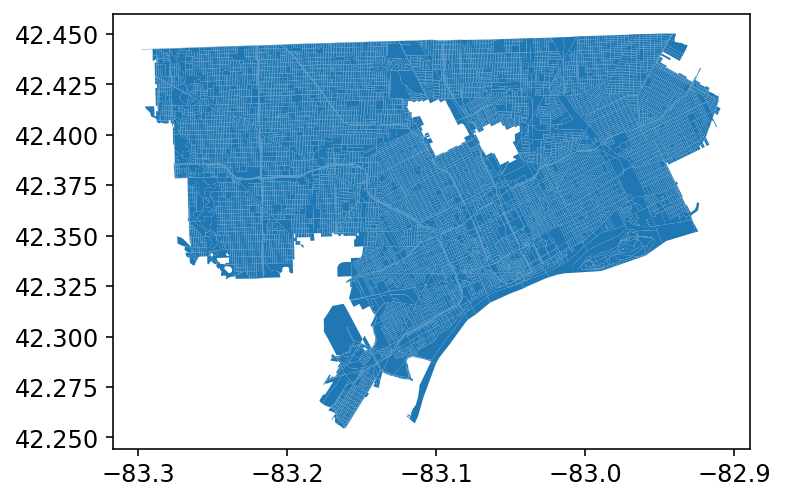

In [194]:
# in_detroit = census.loc[[(db.contains(x)) or (db.overlaps(x)) for x in census.geometry]]

in_detroit_2020.plot()

In [195]:
in_detroit_2020.to_file('/Users/ahakso/Downloads/detroit_census_blocks_2020/blocks_in_detroit_2020.shp')